In [25]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('../dataset/subtitles_dataset_tokenized.csv')
crew_df = pd.read_csv('../dataset/crew.tsv', sep='\t')

In [3]:
# merge datasets
crew_df['IMDB_ID'] = crew_df.tconst.apply(lambda x: int(x.replace('tt', '')))
df = df.merge(right=crew_df, on='IMDB_ID', how='outer')
#df = df.drop(['directors_x', 'writers_x', 'directors_y', 'writers_y'], axis=1)
df = df.drop('tconst', axis=1)
df = df.replace(r'\N', np.nan)

In [4]:
df.set_index('filename', inplace=True)
df.dropna(inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.drop_duplicates(subset='IMDB_ID', inplace=True)

In [6]:
df['main_genre'] = df.genre.str.split(',').apply(lambda x: x[0])

In [7]:
df.drop_duplicates(subset='IMDB_ID', inplace=True)

In [8]:
df['main_genre'] = df.genre.str.split(',').apply(lambda x: x[0])

In [9]:
df.text = df.text.str.replace(r'\(.*?\)', '')

## Load imdb persons file

In [10]:
persons_df = pd.read_csv('../dataset/persons.tsv', sep='\t')
persons_df.shape

(10085356, 6)

In [11]:
persons_df.set_index('nconst', inplace=True)

In [12]:
persons_df.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0050419,tt0043044,tt0053137"
nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0038355,tt0071877,tt0037382"
nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0059956,tt0049189,tt0054452,tt0057345"
nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0077975,tt0078723,tt0080455"
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0060827,tt0050986,tt0050976,tt0083922"


In [13]:
persons_df.loc['nm0000001'].primaryName

'Fred Astaire'

## Get only movies with one single writer

In [37]:
df = df[[len(entry) == 1 for entry in df.writers.str.split(',')]]
df.shape

(3329, 12)

# Analyze writers

In [38]:
writers = df.writers.str.split(',')

In [39]:
df['single_writer'] = df['writers'].apply(lambda x: True if len(x.split(',')) == 1 else False)
df['n_writers'] = df['writers'].apply(lambda x: len(x.split(',')))

In [40]:
df.n_writers.describe()

count    3329.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: n_writers, dtype: float64

In [41]:
df.dropna(inplace=True)

In [42]:
from collections import Counter
writers = Counter((writer for entry in writers for writer in entry))

In [43]:
len(writers)

2462

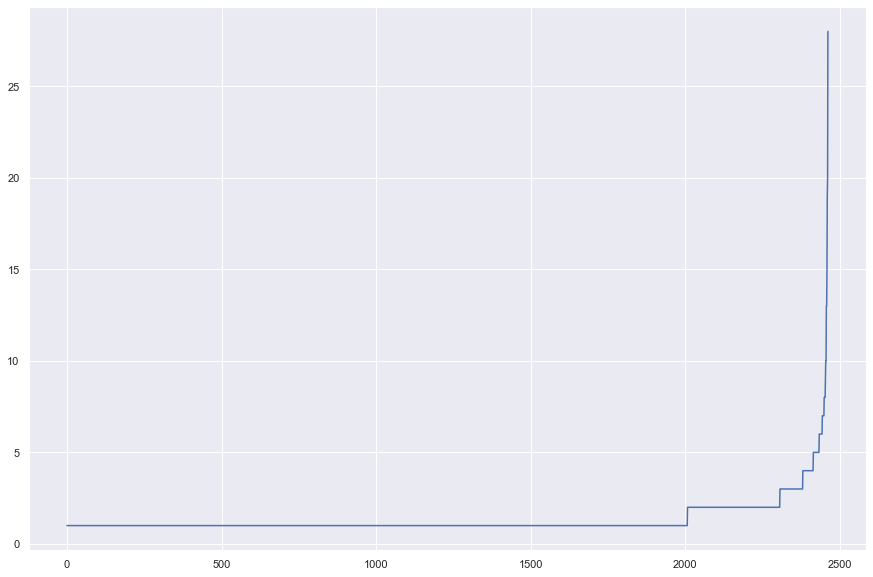

In [44]:
plt.plot(list(sorted(writers.values())))
plt.show()

In [45]:
for writer_id, value in writers.most_common(20):
    print(f'Writer:\n{persons_df.loc[writer_id]} \n\nMovies:  {value}\n\n{"#"*70}')

Writer:
primaryName                                      Woody Allen
birthYear                                               1935
deathYear                                                 \N
primaryProfession                      writer,director,actor
knownForTitles       tt0079522,tt0097123,tt0118954,tt0075686
Name: nm0000095, dtype: object 

Movies:  28

######################################################################
Writer:
primaryName                                   Ingmar Bergman
birthYear                                               1918
deathYear                                               2007
primaryProfession                      writer,director,actor
knownForTitles       tt0060827,tt0050986,tt0050976,tt0083922
Name: nm0000005, dtype: object 

Movies:  20

######################################################################
Writer:
primaryName                                      H.M. Walker
birthYear                                               1878
deathYear 

In [63]:
sample = df[(df.writers.str.contains('nm0000005')) | (df.writers.str.contains('nm0000095'))]
#sample = df[(df.writers.str.contains('nm0000108'))]
#sample = df[((df.year <= 1990) & (1995 >= df.year))]
#sample = df.sample(frac=0.1)

In [64]:
sample.shape

(48, 12)

In [82]:
import spacy
import re
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Iterable, List
from tqdm import tqdm

class POSTransformer(TransformerMixin, BaseEstimator):
    
    def __init__(self, spacy_model: str ='de_core_news_sm', verbose: bool = False):
        self.spacy_model = spacy_model
        self.verbose = verbose     
    
    def fit(self, X, y=None):
        return self

    def transform(self, X: Iterable[str],  y=None):
        pos_tags = set()
        nlp = spacy.load(self.spacy_model)
        Xt = []
        X = tqdm(X) if self.verbose else X
        for x in X:
            doc = nlp(x)
            Xt.append(" ".join([token.pos_ for token in doc]))
        self.tags__ = list(pos_tags)
        return Xt

class SentenceMarkCounter(TransformerMixin):
    
    def __init__(self,
                 marks: List[str] = None,
                 normalize: bool = True,
                 verbose: bool = False,
                 *args,
                 **kwargs):
        self.marks = marks if marks else [r'\.', r'\?', r'!', r'\.{3}']
        self.verbose = verbose
        self.normalize = normalize
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Xt = []
        X = tqdm(X) if self.verbose else X
        for x in X:
            xt = np.array([len(re.findall(mark, x)) for mark in self.marks])
            if self.normalize:
                xt = xt / len(x)
            Xt.append(xt)
        return np.asarray(Xt)        

In [93]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.pipeline import make_pipeline, make_union

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

pos_pipe = make_pipeline(
    POSTransformer(
        verbose=True),
    TfidfVectorizer(
        ngram_range=(1,2)),
    memory=memory
)

token_tdidf = make_pipeline(
    TfidfVectorizer(
        ngram_range=(1,2),
        stop_words=get_stop_words('de'),
        max_features=10000)
)

union = make_union(
    #pos_pipe,
    token_tdidf,
    
)

X = union.fit_transform(sample.text)

pca = PCA(n_components=2)

Xr = pca.fit_transform(X.todense())

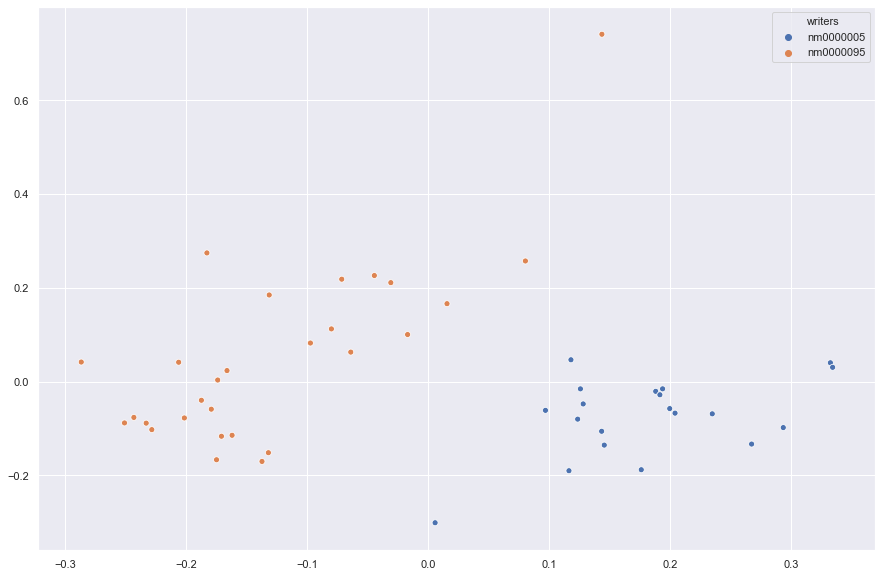

In [94]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
plt.figure
p = sns.scatterplot(x=Xr[:, 0], y=Xr[:, 1], data=sample, hue='writers')

In [ ]:
sum(pca.explained_variance_)

In [ ]:
from yellowbrick.text import UMAPVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
umap = UMAPVisualizer()
umap.fit(X, sample.single_writer)
umap.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

X = TfidfVectorizer(
    #ngram_range=(1,1),
    #stop_words=get_stop_words('de')
).fit_transform(sample.text)

In [ ]:
from sklearn.cluster import DBSCAN, KMeans

In [ ]:
from sklearn.base import ClusterMixin
import matplotlib.pyplot as plt
from typing import Iterable
import numpy as np
from sklearn.base import clone
import time 

def elbow(clu: ClusterMixin, X: np.array, ks: Iterable[int] = tuple(range(2, 11))):
    inertia_values = []
    for k in ks:
        current_clu = clone(clu)
        current_clu.fit(X)
        inertia_values.append(current_clu.inertia_)
        del current_clu
    return inertia_values

In [ ]:
inertias = elbow(KMeans(n_jobs=-1), X)

In [ ]:
plt.plot(list(range(2, 11)), inertias)
plt.show()

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

clu = AffinityPropagation()

clu.fit(X)

In [ ]:
clu.labels_

In [ ]:
import umap
umap = umap.UMAP(n_components=2)
Xr = umap.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xr = pca.fit_transform(X.todense())

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.scatterplot(x=Xr[:, 0], y=Xr[:, 1], data=sample, hue=[f'Cluster {i+1}' for i in clu.labels_])
plt.show()

In [ ]:
plt.hist(clu.labels_, bins=len(set(clu.labels_)))
plt.show()

In [ ]:
clu.labels_.shape

In [ ]:
sample['cluster'] = clu.labels_

In [ ]:
sample.groupby('cluster').year.describe()

In [ ]:
from numpy.linalg import svds

In [ ]:
svds(X)

In [86]:
df.head()

,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,main_genre,single_writer,n_writers
filename,,,,,,,,,,,,
4514303.xml,GENUINE GENUINE Die Geschichte eines Vampirs W...,11221,Horror,1920.0,German,untokenisiert,88,nm0927468,nm0562346,Horror,True,1
3590276.xml,Ein Film mit einem Lächeln ... und vielleicht ...,12349,"Comedy,Drama,Family",1921.0,English,untokenisiert,68,nm0000122,nm0000122,Comedy,True,1
4010305.xml,Die Amalgamated Producing Company zeigt : STAN...,13341,"Comedy,Short",1921.0,English,untokenisiert,17,nm0730386,nm0730386,Comedy,True,1
4259110.xml,DIE HEXE Eine Präsentation aus kultureller und...,13257,"Documentary,Fantasy,Horror",1922.0,"Swedish, Danish",untokenisiert,91,nm0159725,nm0159725,Documentary,True,1
4980988.xml,1923 produzierte Henri Diamant-Berger den erst...,15214,"Sci-Fi,Short",1924.0,French,untokenisiert,35,nm0163229,nm0163229,Sci-Fi,True,1
